In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from numpy.random import seed
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
seed(1)
random.seed(1)
tf.compat.v1.random.set_random_seed(1)

# 1. HYPERPARAMETER CONFIGURATION

In [1]:
n_out = 1  # Number of output features
seq_len = 110  # Sequence length (time steps for LSTM input)
hidden_units = 128  # Number of hidden units in LSTM layers
dropout_size = 0.2  # Dropout rate
lr = 1e-3  # Learning rate
decay = 1e-5  # Learning rate decay
batch_size = 64  # Batch size
epochs = 100  # Maximum number of training epochs

# 2. DATA LOADING AND PREPROCESSING

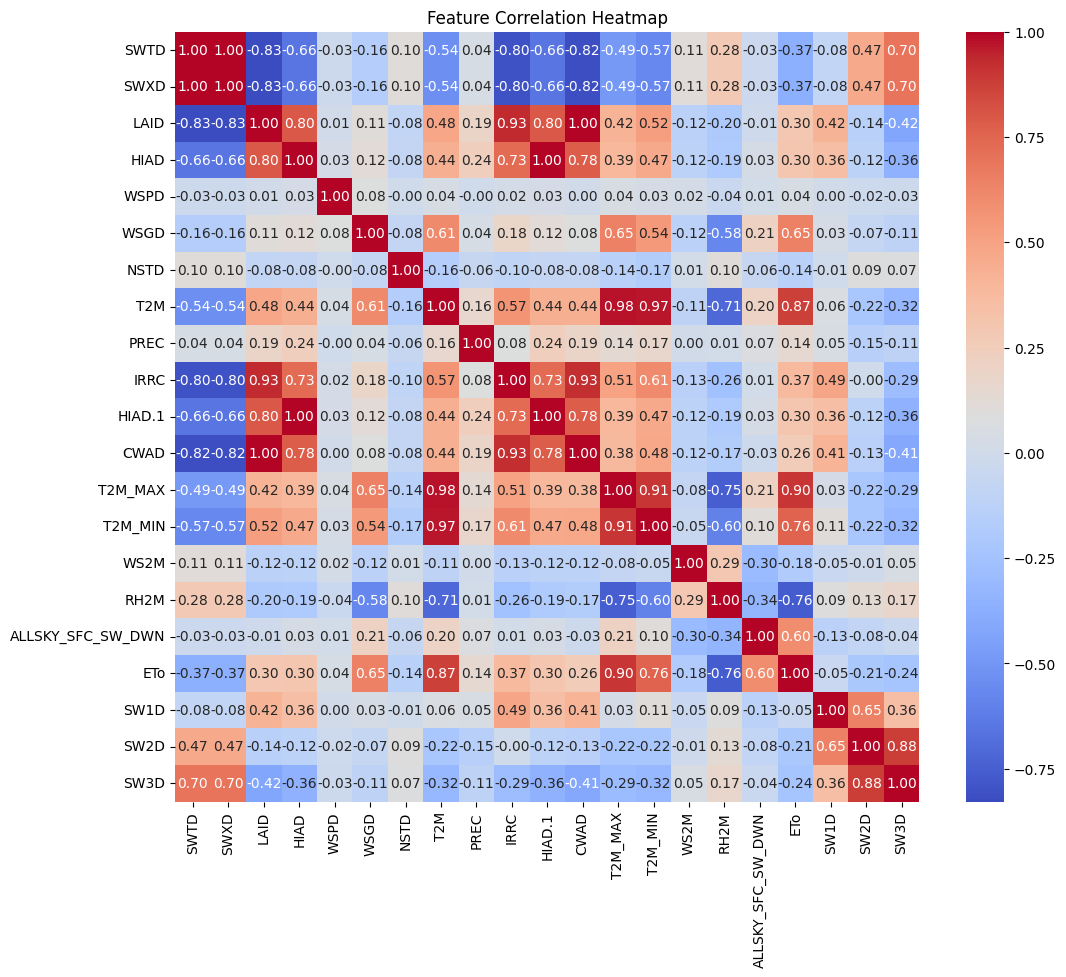

PCA Reduced Dimensions: 8


In [ ]:
# Load dataset
dataset_path = '/content/drive/MyDrive/FASI/output_data2.csv'  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Set index to 'date' and drop missing values
df.set_index('date', inplace=True)
df.dropna(inplace=True)

# Feature correlation analysis
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Add interaction terms
df['PREC_SWXD'] = df['PREC'] * df['SWTD']
df['IRRC_SWTD'] = df['IRRC'] * df['SWTD']

# Define preprocessing function
def data_preprocessing(df):
    values = df.values
    scaler = MinMaxScaler()
    values_normalized = scaler.fit_transform(values)
    df_normalized = pd.DataFrame(values_normalized, columns=df.columns, index=df.index)
    return df_normalized, scaler

# Normalize the data
data_normalized, feature_scaler = data_preprocessing(df)
# Separate target variable (CWAD) for independent scaling
target_scaler = MinMaxScaler()
data_normalized['CWAD'] = target_scaler.fit_transform(data_normalized[['CWAD']])

# Apply PCA to reduce dimensions
pca = PCA(n_components=0.95)  # Retain 95% variance
data_pca = pca.fit_transform(data_normalized)
print(f"PCA Reduced Dimensions: {data_pca.shape[1]}")

# 3. DATA SPLITTING FOR TRAINING

In [ ]:
def data_split(X, y, seq_len):
    """
    Create sequences of input data and corresponding targets.
    Args:
        X (np.array): Feature array.
        y (np.array): Target array.
        seq_len (int): Length of each sequence.
    Returns:
        np.array: Input sequences.
        np.array: Output targets.
    """
    X_sequences, Y_targets = [], []
    for i in range(len(X) - seq_len):
        X_sequences.append(X[i:i + seq_len])
        Y_targets.append(y[i + seq_len])
    return np.array(X_sequences), np.array(Y_targets)

# Prepare features and target
X = data_pca
y = data_normalized['CWAD'].values  # Output is CWAD

# Create sequences
X_lstm, y_lstm = data_split(X, y, seq_len)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=1)

# 4. LSTM MODEL DEFINITION


In [ ]:
def lstm_model():
    """
    Build and compile the LSTM model.
    Returns:
        tf.keras.Model: Compiled LSTM model.
    """
    input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    blstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=True),
        name='blstm1')(input_layer)
    dropout = tf.keras.layers.Dropout(dropout_size)(blstm)
    blstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=False),
        name='blstm2')(dropout)
    dropout = tf.keras.layers.Dropout(dropout_size)(blstm)
    dense = tf.keras.layers.Dense(hidden_units, activation='tanh')(dropout)
    output_layer = tf.keras.layers.Dense(n_out)(dense)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay=decay)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = lstm_model()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# 5. TRAINING THE MODEL

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00564, saving model to cwad_prediction_model.keras
29/29 - 38s - 1s/step - loss: 0.0118 - mae: 0.0694 - val_loss: 0.0056 - val_mae: 0.0447
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00564
29/29 - 32s - 1s/step - loss: 0.0068 - mae: 0.0452 - val_loss: 0.0061 - val_mae: 0.0442
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00564
29/29 - 40s - 1s/step - loss: 0.0068 - mae: 0.0446 - val_loss: 0.0069 - val_mae: 0.0434
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00564
29/29 - 40s - 1s/step - loss: 0.0064 - mae: 0.0407 - val_loss: 0.0058 - val_mae: 0.0387
Epoch 5/100

Epoch 5: val_loss improved from 0.00564 to 0.00513, saving model to cwad_prediction_model.keras
29/29 - 43s - 1s/step - loss: 0.0057 - mae: 0.0381 - val_loss: 0.0051 - val_mae: 0.0355
Epoch 6/100

Epoch 6: val_loss did not improve from 0.00513
29/29 - 40s - 1s/step - loss: 0.0055 - mae: 0.0363 - val_loss: 0.0053 - val_mae: 0.0357
Epoch 7/100

Epoch

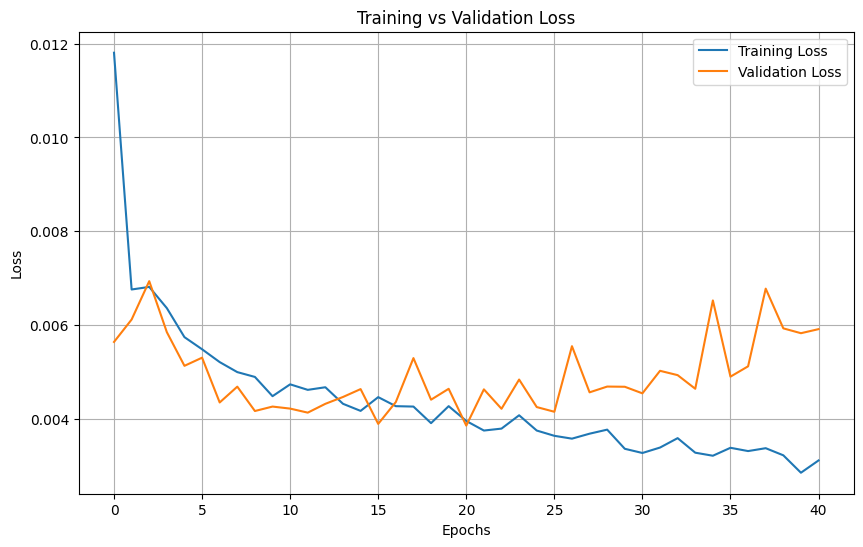

In [ ]:
def train_model():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True
    )
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        verbose=2,
        shuffle=True,
        callbacks=[checkpoint, early_stopping]
    )
    return history

history = train_model()

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 6. MODEL EVALUATION

In [ ]:
# Evaluate the model on test data
lstm_predictions = model.predict(X_test)
# Denormalize the test data and predictions
y_test_denormalized = target_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0] # Use target_scaler for y_test
y_pred_denormalized = target_scaler.inverse_transform(lstm_predictions.reshape(-1, 1))[:, 0] # Use target_scaler for lstm_predictions
# Calculate R² and MSE
mse = mean_squared_error(y_test_denormalized, y_pred_denormalized)
r2 = r2_score(y_test_denormalized, y_pred_denormalized)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step
Mean Squared Error: 0.002490963275863203
R-squared: 0.9188550950012522


# 7. RESULTS VISUALIZATION

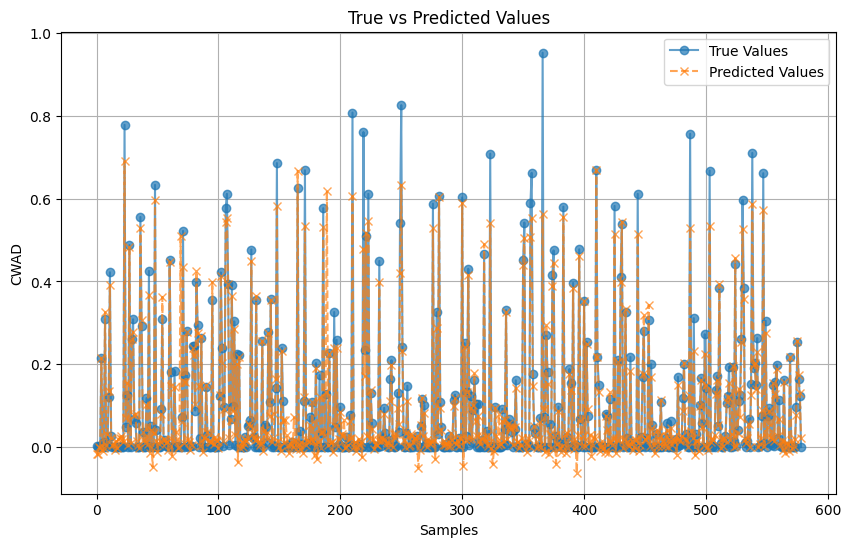

In [ ]:
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_denormalized, label="True Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred_denormalized, label="Predicted Values", marker='x', linestyle='--', alpha=0.7)
plt.title("True vs Predicted Values")
plt.xlabel("Samples")
plt.ylabel("CWAD")
plt.legend()
plt.grid(True)
plt.show()

# 8. SAVE RESULTS

In [ ]:
# Save predictions to CSV
output_data = pd.DataFrame({
    'True_Values': y_test_denormalized,
    'Predicted_Values': y_pred_denormalized
})
output_data.to_csv("cwad_predictions.csv", index=False)
print("Predictions saved to 'cwad_predictions.csv'")

Predictions saved to 'cwad_predictions.csv'


In [ ]:
model.save("/content/drive/MyDrive/FASI/LSTM2.keras")